In [2]:
!pip install tensorflow

In [3]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121


In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = './'
train_dir = 'PlantVillage'

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, 'train', sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/55bcfcce-70f4-4634-8107-0a8207d...,14,Tomato_healthy
20635,Tomato_healthy/81024038-40ff-40c4-b8f4-4a48b08...,14,Tomato_healthy
20636,Tomato_healthy/058ade43-2361-4039-bbe5-0ac6618...,14,Tomato_healthy
20637,Tomato_healthy/2e485f1d-5aa5-4d56-8733-9625ed4...,14,Tomato_healthy
20638,Tomato_healthy/d984f436-1fde-4221-9563-82f55a4...,14,Tomato_healthy


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/7181181c-b571-4cf0-80c3-c52bd78...,14,Tomato_healthy
1,Potato___Early_blight/89d4dba2-3d9c-46fe-bac3-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/18f0fcbe-a99c-4d0d-a...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/621419a1-09f2-4a22-a569-6d81038...,14,Tomato_healthy
4,Tomato_Leaf_Mold/6ffea8bd-57cd-4fcf-b477-decec...,8,Tomato_Leaf_Mold


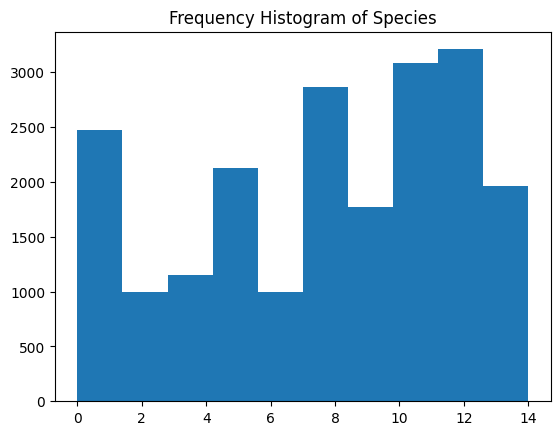

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

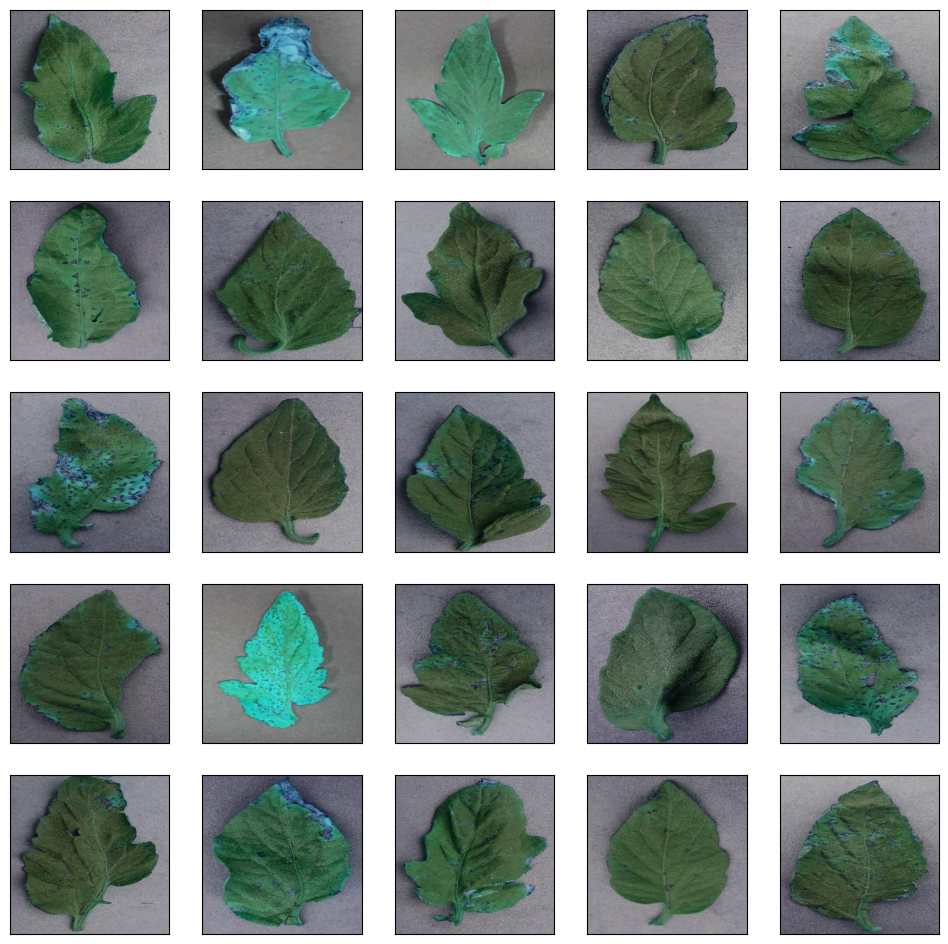

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, 'PlantVillage', defect_files[n])
            image = cv2.imread(image_path)
            if image is not None:
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].imshow(image)
            else:
                print(f"Error loading image: {image_path}")
            n += 1

plot_defects('Tomato_Bacterial_spot', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, 'PlantVillage', filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [13]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [ ]:
valid_images = []
valid_labels = []

for idx, row in tqdm(train.iterrows(), total=len(train)):
    file = row['File']
    image = read_image(file)
    if image is not None and image.sum() != 0:
        resized = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        valid_images.append(resized)
        valid_labels.append(row['DiseaseID'])
    else:
        print(f"Skipping: {file} (invalid or unreadable)")

# Convert to numpy arrays
X_data = np.array(valid_images) / 255.  # Normalize
Y_data = to_categorical(np.array(valid_labels), num_classes=15)

print(f"Loaded {len(X_data)} valid images.")



 73%|███████▎  | 14964/20639 [00:24<00:09, 612.74it/s]

Skipping: Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c (invalid or unreadable)


100%|██████████| 20639/20639 [00:33<00:00, 610.93it/s]


Loaded 20638 valid images.


In [ ]:
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=SEED)

In [ ]:
# Check if image is valid
print(X_train[0].sum(), X_train[1].sum(), X_train[2].sum())

5323.647058823529 5167.019607843137 6680.058823529411


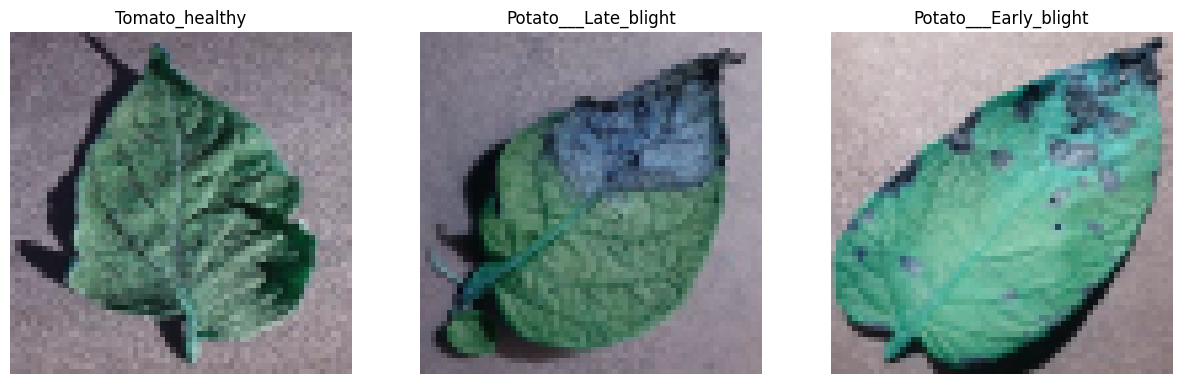

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])


In [19]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multiple output
    output = Dense(15,activation = 'softmax', name='root')(x)

    model = Model(input,output)

    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data along with data augmentations
datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

datagen.fit(X_train)

hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,308,963 (27.88 MB)

 Trainable params: 7,222,755 (27.55 MB)

 Non-trainable params: 86,208 (336.75 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.51814, saving model to model.h5


257/257 - 670s - 3s/step - accuracy: 0.2913 - loss: 2.6921 - val_accuracy: 0.5373 - val_loss: 1.5181 - learning_rate: 0.0020
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.51814
257/257 - 44s - 172ms/step - accuracy: 0.4688 - loss: 1.7010 - val_accuracy: 0.5354 - val_loss: 1.5186 - learning_rate: 0.0020
Epoch 3/50

Epoch 3: val_loss improved from 1.51814 to 0.94940, saving model to model.h5


257/257 - 623s - 2s/step - accuracy: 0.6211 - loss: 1.2187 - val_accuracy: 0.7023 - val_loss: 0.9494 - learning_rate: 0.0020
Epoch 4/50

Epoch 4: val_loss did not improve from 0.94940
257/257 - 34s - 131ms/step - accuracy: 0.6719 - loss: 0.8437 - val_accuracy: 0.6638 - val_loss: 1.0920 - learning_rate: 0.0020
Epoch 5/50

Epoch 5: val_loss improved from 0.94940 to 0.59171, saving model to model.h5


257/257 - 622s - 2s/step - accuracy: 0.7417 - loss: 0.8008 - val_accuracy: 0.7938 - val_loss: 0.5917 - learning_rate: 0.0020
Epoch 6/50

Epoch 6: val_loss improved from 0.59171 to 0.57440, saving model to model.h5


257/257 - 44s - 172ms/step - accuracy: 0.7969 - loss: 0.5189 - val_accuracy: 0.8009 - val_loss: 0.5744 - learning_rate: 0.0020
Epoch 7/50

Epoch 7: val_loss did not improve from 0.57440
257/257 - 636s - 2s/step - accuracy: 0.8186 - loss: 0.5495 - val_accuracy: 0.6873 - val_loss: 1.0855 - learning_rate: 0.0020
Epoch 8/50

Epoch 8: val_loss did not improve from 0.57440
257/257 - 43s - 169ms/step - accuracy: 0.8594 - loss: 0.4847 - val_accuracy: 0.7250 - val_loss: 0.9079 - learning_rate: 0.0020
Epoch 9/50

Epoch 9: val_loss improved from 0.57440 to 0.34112, saving model to model.h5


257/257 - 630s - 2s/step - accuracy: 0.8657 - loss: 0.4139 - val_accuracy: 0.8893 - val_loss: 0.3411 - learning_rate: 0.0020
Epoch 10/50

Epoch 10: val_loss did not improve from 0.34112
257/257 - 43s - 168ms/step - accuracy: 0.8281 - loss: 0.4309 - val_accuracy: 0.8803 - val_loss: 0.3635 - learning_rate: 0.0020
Epoch 11/50

Epoch 11: val_loss did not improve from 0.34112
257/257 - 651s - 3s/step - accuracy: 0.8880 - loss: 0.3478 - val_accuracy: 0.8433 - val_loss: 0.4928 - learning_rate: 0.0020
Epoch 12/50

Epoch 12: val_loss did not improve from 0.34112
257/257 - 43s - 168ms/step - accuracy: 0.9844 - loss: 0.1713 - val_accuracy: 0.8387 - val_loss: 0.5086 - learning_rate: 0.0020
Epoch 13/50

Epoch 13: val_loss did not improve from 0.34112
257/257 - 636s - 2s/step - accuracy: 0.9058 - loss: 0.2912 - val_accuracy: 0.7318 - val_loss: 1.0118 - learning_rate: 0.0020
Epoch 14/50

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 14: val_loss did not improve f

257/257 - 641s - 2s/step - accuracy: 0.9252 - loss: 0.2311 - val_accuracy: 0.9016 - val_loss: 0.3006 - learning_rate: 1.0000e-03
Epoch 16/50

Epoch 16: val_loss did not improve from 0.30057
257/257 - 43s - 168ms/step - accuracy: 0.9062 - loss: 0.2422 - val_accuracy: 0.8970 - val_loss: 0.3193 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 17: val_loss did not improve from 0.30057
257/257 - 622s - 2s/step - accuracy: 0.9324 - loss: 0.2044 - val_accuracy: 0.8081 - val_loss: 0.6671 - learning_rate: 1.0000e-03
Epoch 18/50

Epoch 18: val_loss did not improve from 0.30057
257/257 - 43s - 168ms/step - accuracy: 0.9844 - loss: 0.0770 - val_accuracy: 0.7999 - val_loss: 0.7038 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 19: val_loss improved from 0.30057 to 0.21351, saving model to model.h5


257/257 - 615s - 2s/step - accuracy: 0.9388 - loss: 0.1891 - val_accuracy: 0.9363 - val_loss: 0.2135 - learning_rate: 1.0000e-03
Epoch 20/50

Epoch 20: val_loss did not improve from 0.21351
257/257 - 44s - 169ms/step - accuracy: 0.9688 - loss: 0.1701 - val_accuracy: 0.9358 - val_loss: 0.2150 - learning_rate: 1.0000e-03
Epoch 21/50

Epoch 21: val_loss did not improve from 0.21351
257/257 - 643s - 3s/step - accuracy: 0.9423 - loss: 0.1765 - val_accuracy: 0.9150 - val_loss: 0.3666 - learning_rate: 1.0000e-03
Epoch 22/50

Epoch 22: val_loss did not improve from 0.21351
257/257 - 43s - 168ms/step - accuracy: 0.9531 - loss: 0.1381 - val_accuracy: 0.9096 - val_loss: 0.3992 - learning_rate: 1.0000e-03
Epoch 23/50

Epoch 23: val_loss improved from 0.21351 to 0.14876, saving model to model.h5


257/257 - 644s - 3s/step - accuracy: 0.9450 - loss: 0.1701 - val_accuracy: 0.9499 - val_loss: 0.1488 - learning_rate: 1.0000e-03
Epoch 24/50

Epoch 24: val_loss did not improve from 0.14876
257/257 - 43s - 169ms/step - accuracy: 0.9844 - loss: 0.0534 - val_accuracy: 0.9491 - val_loss: 0.1546 - learning_rate: 1.0000e-03
Epoch 25/50

Epoch 25: val_loss did not improve from 0.14876
257/257 - 634s - 2s/step - accuracy: 0.9506 - loss: 0.1555 - val_accuracy: 0.8312 - val_loss: 0.5808 - learning_rate: 1.0000e-03
Epoch 26/50

Epoch 26: val_loss did not improve from 0.14876
257/257 - 43s - 168ms/step - accuracy: 0.9531 - loss: 0.1203 - val_accuracy: 0.8106 - val_loss: 0.6721 - learning_rate: 1.0000e-03
Epoch 27/50

Epoch 27: val_loss did not improve from 0.14876
257/257 - 620s - 2s/step - accuracy: 0.9514 - loss: 0.1469 - val_accuracy: 0.9070 - val_loss: 0.3614 - learning_rate: 1.0000e-03
Epoch 28/50

Epoch 28: val_loss did not improve from 0.14876
257/257 - 43s - 168ms/step - accuracy: 0.9531 

### Comment
At the end of epoch 50, we can see a validation accuracy of 94.60% and validation loss of 20.89% which shows that the model has learnt well and is able to generalize well.

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.9455 - loss: 0.2101
Final Loss: 0.20888659358024597, Final Accuracy: 0.9459787011146545


129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step


Text(0.5, 192.58159722222217, 'Predicted')

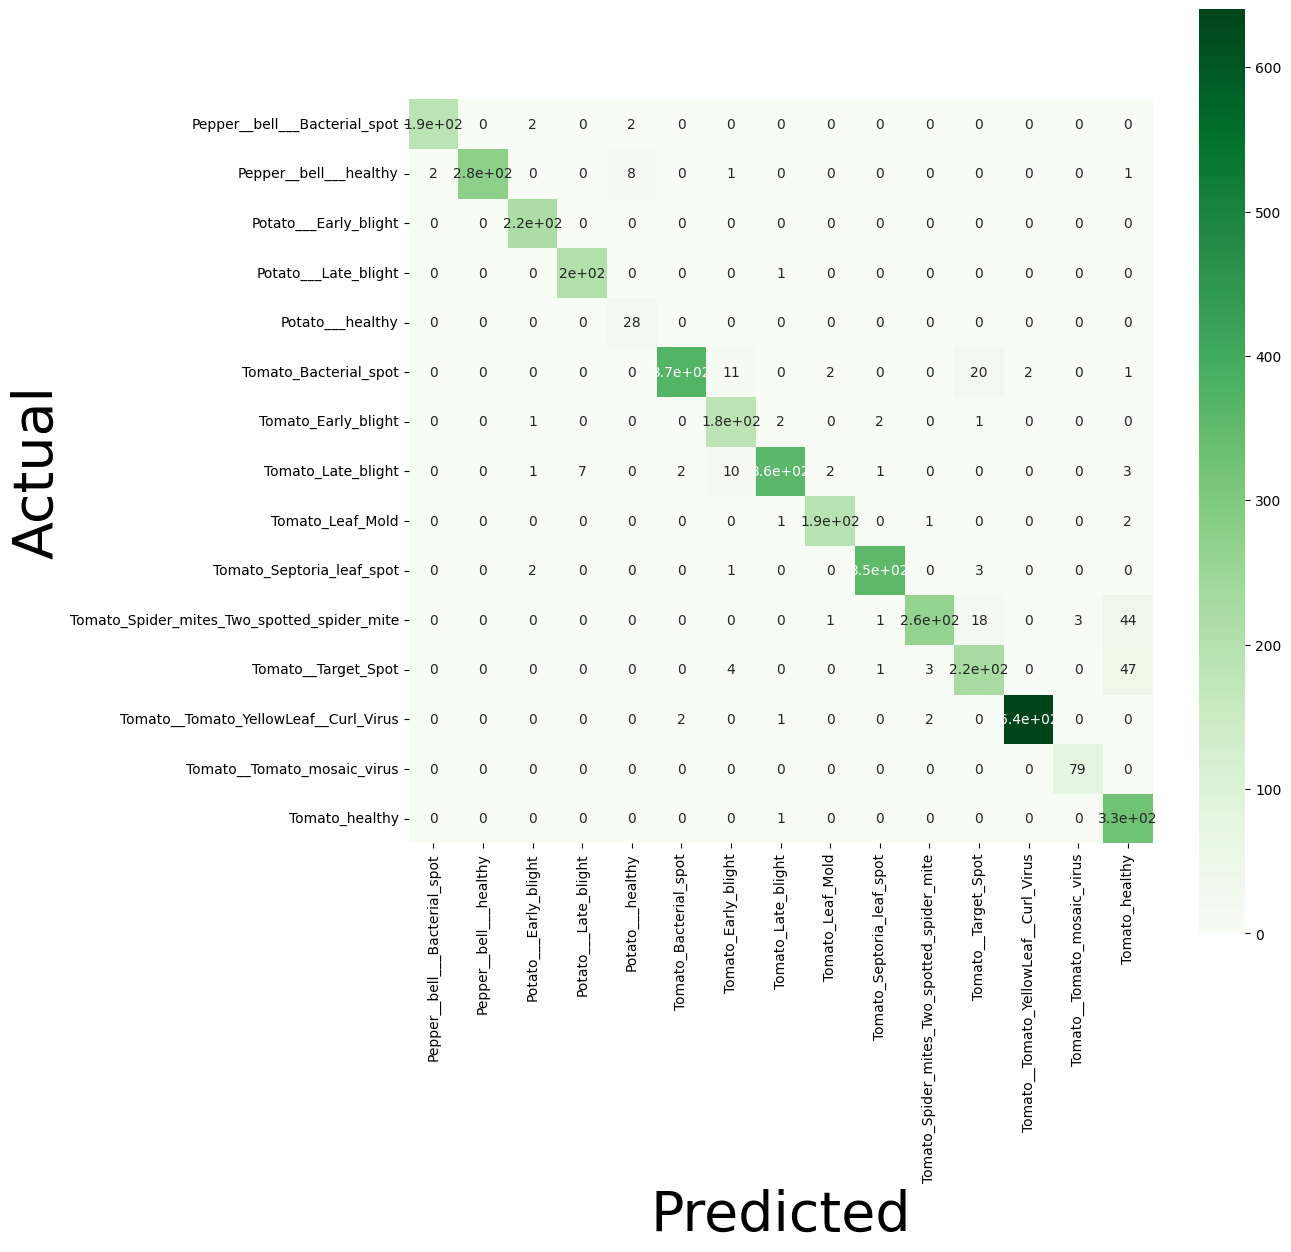

In [ ]:
# Confusion Matrix
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

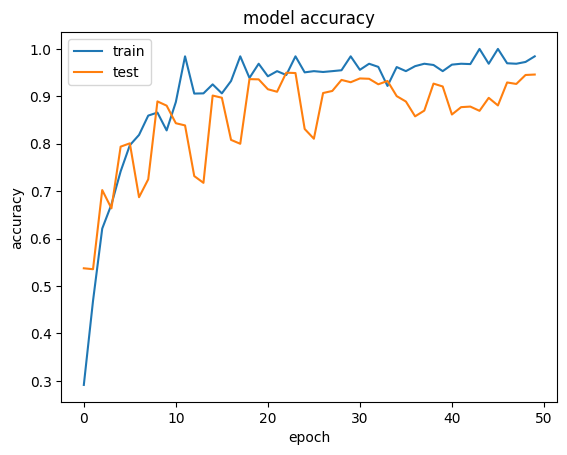

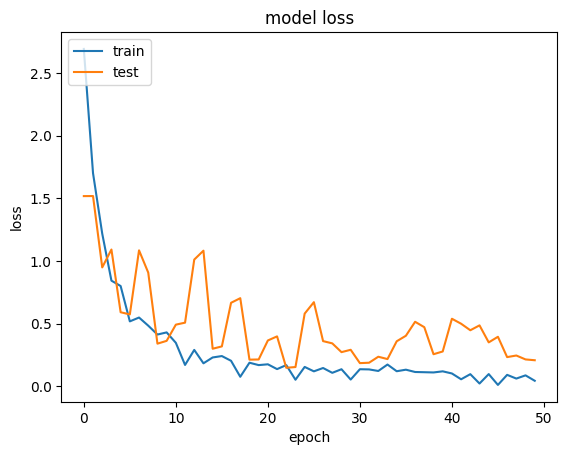

In [ ]:
# Train vs Test Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Train vs Test Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Disease Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[2.8890884e-04 4.1911617e-06 3.7773661e-03 2.5654470e-05 1.7585156e-05
 4.4262694e-07 1.0663309e-01 2.7471597e-03 9.4797248e-03 8.7651521e-01
 3.5649748e-07 3.9499282e-06 8.8780807e-06 4.9374485e-04 3.7732668e-06]


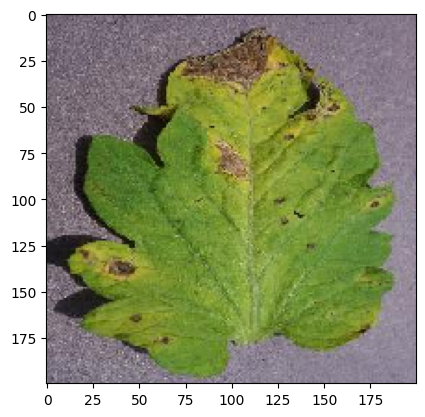

Prediction: Tomato_Septoria_leaf_spot


In [ ]:
from skimage import io
from keras.preprocessing import image
import numpy as np

# Input is Tomato Septoria Leaf Spot
img = image.load_img('Tomato_Septoria_leaf_spot/0025c401-7785-49c5-8bef-780a8a0d3652___Matt.S_CG 2694.JPG', color_mode='rgb', target_size=(64, 64))
show_img=image.load_img('Tomato_Septoria_leaf_spot/0025c401-7785-49c5-8bef-780a8a0d3652___Matt.S_CG 2694.JPG', color_mode='rgb', target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)

print('Prediction:',disease_class[ind])

### Comment:
We can see from the above cell that the model is able to correctly predict the type of disease based on the image provided.

In [40]:
# Convert to TFLite in Colab
import tensorflow as tf

model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpq_82ns8_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  137659919060240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659919061968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659910282832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659922809872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659922808912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659910290704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659910290320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659922810640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659922811024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659922809680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13765992281025